# Digit Predictor

For this notebook, I am going to build out a handwritten number predictor using the popular, [mnist](https://www.tensorflow.org/datasets/catalog/mnist) dataset. This dataset is popular in machine learning when diving into the architectures of Convolutional Neural Networks.

The `mnist` dataset has images of hand written digits in gray scale coloring.

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

/Users/brandonkubick/Code/deep-learning-development/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment
Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-08 19:04:41.959820


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 42

## Downloading, Analyzing, & Creating Datasets

The dataset for this notebook is looking at very pixelated images of clothing.

* https://www.tensorflow.org/datasets/catalog/mnist

### Downloading Dataset

**NOTE** I do not batch the data initially in order to use some of the `tfds` analysis utilities. I will prepare the datasets after analysis.

In [9]:
(train_dataset, test_dataset), data_info = tfds.load(name='mnist',
                                                     split=['train', 'test'],
                                                     shuffle_files=True,
                                                     as_supervised=True,  # Return type is tuple of (data, label)
                                                     with_info=True)

INFO:absl:Load dataset info from /Users/brandonkubick/tensorflow_datasets/mnist/3.0.1
INFO:absl:For 'mnist/3.0.1': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/brandonkubick/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], from /Users/brandonkubick/tensorflow_datasets/mnist/3.0.1


### Analyzing Dataset

In [10]:
data_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/brandonkubick/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [11]:
class_names = data_info.features['label'].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [12]:
total_classes = data_info.features['label'].num_classes
total_classes

10

2023-10-08 19:04:42.071536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


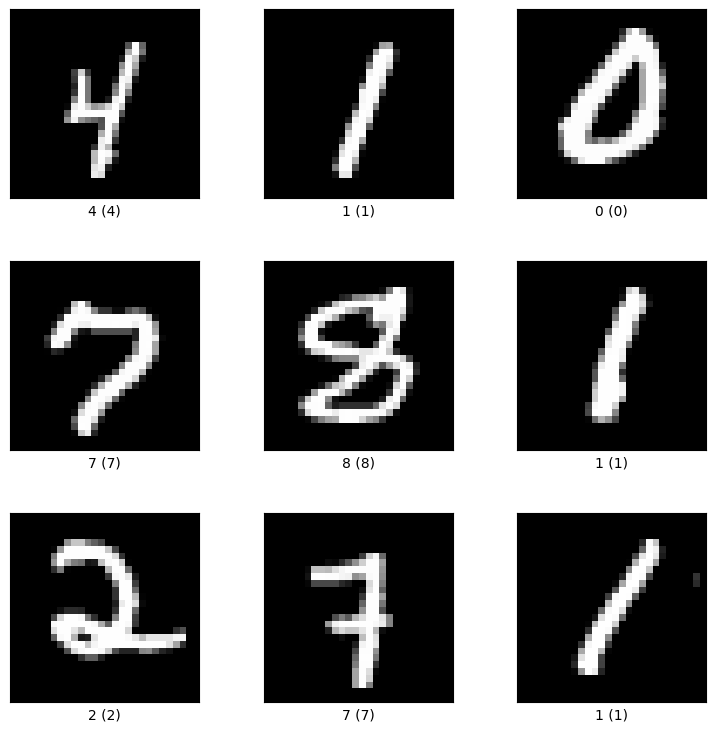

In [13]:
tfds.show_examples(train_dataset, data_info);

In [14]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [15]:
batch = train_dataset.take(1)
image, label = next(iter(batch))

print(f'Image Shape: {image.shape}')
print(f'Label Shape: {label.shape}')
print(f'Image Max Value: {tf.reduce_max(image)} (Whether or not I need to scale the values)')

Image Shape: (28, 28, 1)
Label Shape: ()
Image Max Value: 255 (Whether or not I need to scale the values)


2023-10-08 19:04:42.348137: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
tfds.benchmark(train_dataset.batch(32).prefetch(tf.data.AUTOTUNE), batch_size=32)


************ Summary ************



100%|████████████████████████████████████████| 1875/1875 [00:00<00:00, 2354.70it/s]

Examples/sec (First included) 73348.44 ex/sec (total: 60032 ex, 0.82 sec)
Examples/sec (First only) 1131.86 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 75932.30 ex/sec (total: 60000 ex, 0.79 sec)


,duration,num_examples,avg
first+lasts,0.818450,60032,73348.443513
first,0.028272,32,1131.861913
lasts,0.790178,60000,75932.302313


### Prepare Datasets

In [17]:
batched_train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
batched_test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

batched_train_dataset, batched_test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Experiments

I am going to run a handful of experiments to include custom CNN architectures, along with Transfer Learning to get a bit of experience with both.

* Experiment-0 (Baseline): Feed Forward Network
* Experiment-1: Conv2D-MaxPooling2D
* Experiment-2: Conv2D-Conv2D-MaxPooling2D
* Experiment-3: Conv2D-Conv2D-MaxPooling2D w/ Regularization
* Experiment-4: Conv2D-Conv2D-MaxPooling2D w/ Data Augmentation
* Experiment-5: EfficientNet
* Experiment-6: Double Conv2D-MaxPooling2D w/ Lower Learning Rate
* Experiment-7: Double Conv2D-MaxPooling2D-Dropout w/ Lower Learning Rate

**NOTE**: The labels data is encoded, but not one-hot-encoded. This implies that I need to use `SparseCategoricalCrossentropy`.

### Constants

In [18]:
IMAGE_SIZE = 28

INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)

CLASS_NAMES = data_info.features['label'].names
TOTAL_CLASSES = data_info.features['label'].num_classes

### Preprocessing Layers

After analyzing the data, I now know that I need to perform at the bare minimum, scaling of the values.

In [19]:
preprocessing = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
], name='preprocessing_layers')

In [20]:
augmented_preprocessing = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.Rescaling(scale=1./255),
], name='data_augmentation_preprocessing_layers')

In [21]:
efficientnet_preprocessing = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(32, 32)
], name='efficientnet_preprocessing_layers')

### Experiment-0 (Baseline): Feed Forward Network

In [22]:
# Constants
model_0_name = 'model_0_feed_forward'

In [23]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    preprocessing,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_0_name)

model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_0_history = model_0.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 644us/step - loss: 0.4357 - accuracy: 0.8767 - val_loss: 0.2502 - val_accuracy: 0.9298
Epoch 2/5
1875/1875 [==============================] - 1s 548us/step - loss: 0.2385 - accuracy: 0.9311 - val_loss: 0.2174 - val_accuracy: 0.9378
Epoch 3/5
1875/1875 [==============================] - 1s 531us/step - loss: 0.2062 - accuracy: 0.9406 - val_loss: 0.2017 - val_accuracy: 0.9421
Epoch 4/5
1875/1875 [==============================] - 1s 544us/step - loss: 0.1872 - accuracy: 0.9461 - val_loss: 0.1930 - val_accuracy: 0.9451
Epoch 5/5
1875/1875 [==============================] - 1s 533us/step - loss: 0.1742 - accuracy: 0.9497 - val_loss: 0.1878 - val_accuracy: 0.9468


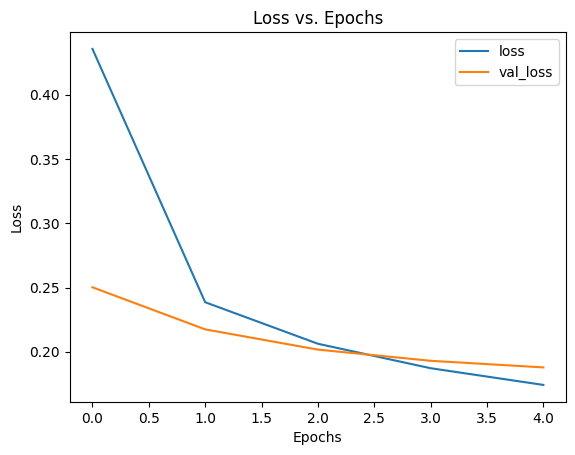

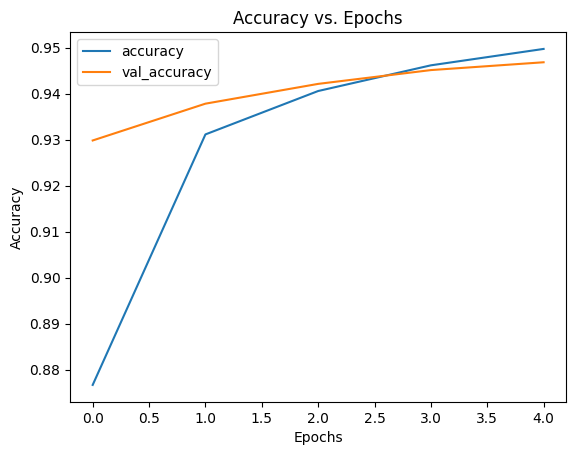

In [24]:
ml_toolbox.analysis.history.plot_history(model_0_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_0_history, 'accuracy')

In [25]:
model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_0)
model_0_results

ClassificationPredictionMetrics(accuracy=0.9468, precision=0.9473662352220202, recall=0.9468, f1=0.946816920718934, name='model_0_feed_forward')

### Experiment-1: Conv2D-MaxPooling2D

In [26]:
# Constants
model_1_name = 'model_1_conv_pool'

In [27]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    preprocessing,
    tf.keras.layers.Conv2D(16, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_1_name)

model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_1_history = model_1.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3033 - accuracy: 0.9145 - val_loss: 0.1810 - val_accuracy: 0.9487
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1463 - accuracy: 0.9580 - val_loss: 0.1228 - val_accuracy: 0.9664
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1048 - accuracy: 0.9697 - val_loss: 0.0995 - val_accuracy: 0.9719
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0840 - accuracy: 0.9760 - val_loss: 0.0879 - val_accuracy: 0.9740
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0707 - accuracy: 0.9799 - val_loss: 0.0822 - val_accuracy: 0.9749


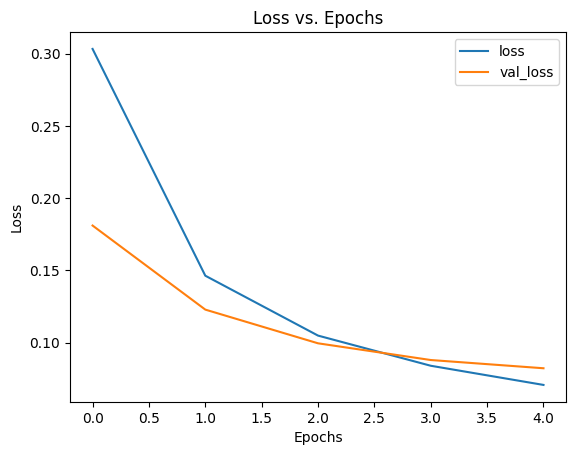

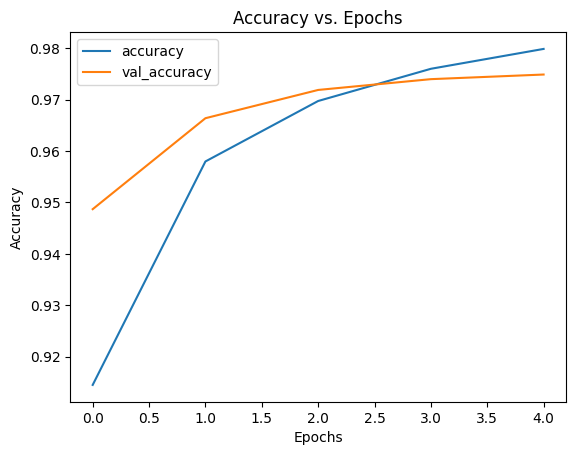

In [28]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_1_history, 'accuracy')

In [29]:
model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_1)
model_1_results

ClassificationPredictionMetrics(accuracy=0.9749, precision=0.9749774041923456, recall=0.9749, f1=0.9748772618616689, name='model_1_conv_pool')

### Experiment-2: Conv2D-Conv2D-MaxPooling2D

In [30]:
# Constants
model_2_name = 'model_2_conv_conv_pool'

In [31]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    preprocessing,
    tf.keras.layers.Conv2D(16, 3),
    tf.keras.layers.Conv2D(16, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_2_name)

model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_2_history = model_2.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2218 - accuracy: 0.9348 - val_loss: 0.1056 - val_accuracy: 0.9674
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0899 - accuracy: 0.9726 - val_loss: 0.0825 - val_accuracy: 0.9735
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0692 - accuracy: 0.9793 - val_loss: 0.0814 - val_accuracy: 0.9744
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0578 - accuracy: 0.9826 - val_loss: 0.0852 - val_accuracy: 0.9747
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0492 - accuracy: 0.9850 - val_loss: 0.0933 - val_accuracy: 0.9737


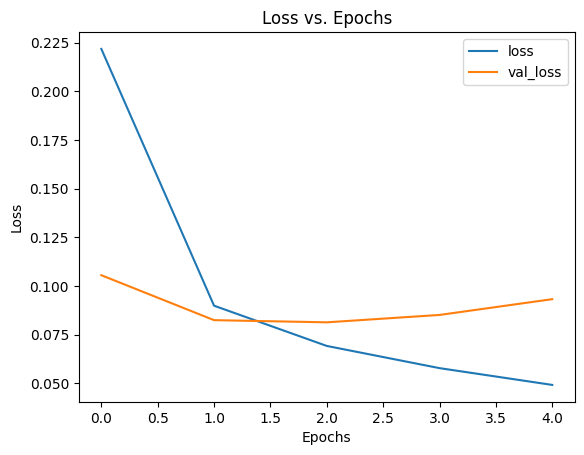

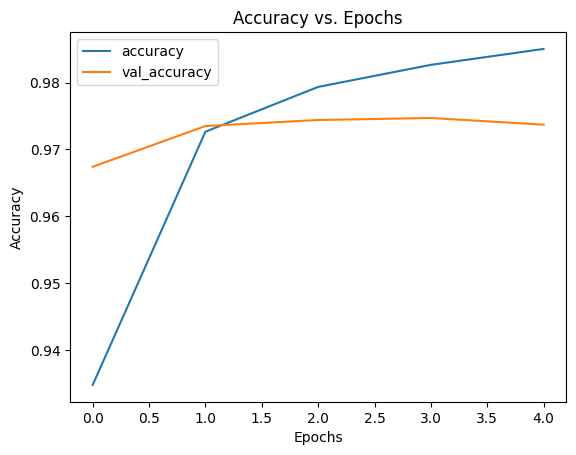

In [32]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_2_history, 'accuracy')

In [33]:
model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_2)
model_2_results

ClassificationPredictionMetrics(accuracy=0.9737, precision=0.9741181872528326, recall=0.9737, f1=0.973723834518757, name='model_2_conv_conv_pool')

#### Finding
After running through Experiment-2 and looking at the loss plots, it is evident that the model is overfitting the training data. Ways to solve overfitting include:

* Data Augmentation
* Regularization
* EarlyStoppings


### Experiment-3: Conv2D-Conv2D-MaxPooling w/ Regularization

In [34]:
# Constants
model_3_name = 'model_3_conv_conv_pool_reg'

In [35]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    preprocessing,
    tf.keras.layers.Conv2D(16, 5, kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    tf.keras.layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_3_name)

model_3.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_3_history = model_3.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4625 - accuracy: 0.9245 - val_loss: 0.2399 - val_accuracy: 0.9592
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2338 - accuracy: 0.9592 - val_loss: 0.1983 - val_accuracy: 0.9665
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2060 - accuracy: 0.9651 - val_loss: 0.1818 - val_accuracy: 0.9694
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1910 - accuracy: 0.9686 - val_loss: 0.1745 - val_accuracy: 0.9709
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1810 - accuracy: 0.9711 - val_loss: 0.1687 - val_accuracy: 0.9724


In [36]:
model_3.summary()

Model: "model_3_conv_conv_pool_reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing_layers (Sequ  (None, 28, 28, 1)         0         
 ential)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3872)              0         
                                                                 
 dense_5 (Dense)             (None, 10) 

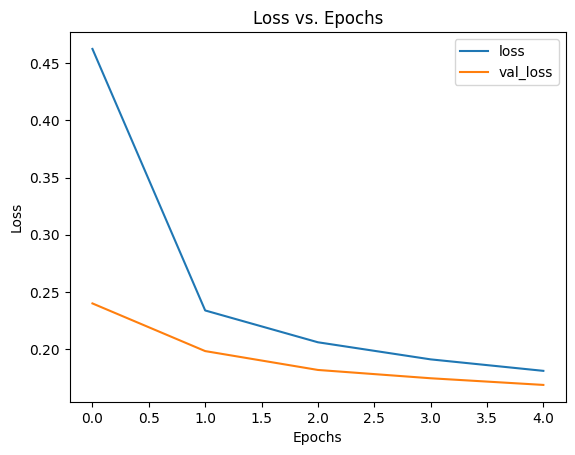

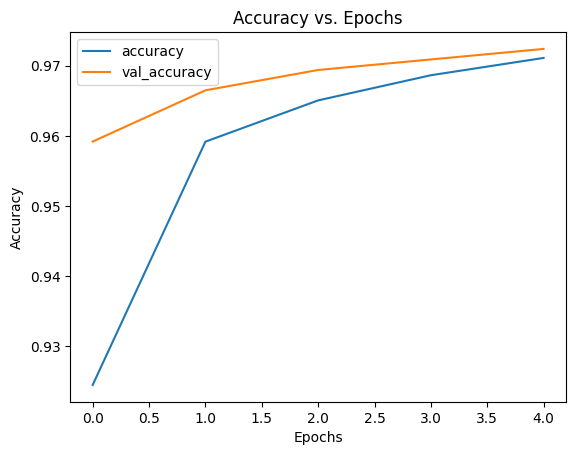

In [37]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_3_history, 'accuracy')

In [38]:
model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_3)
model_3_results

ClassificationPredictionMetrics(accuracy=0.9724, precision=0.9725161701486559, recall=0.9724, f1=0.9723895446899904, name='model_3_conv_conv_pool_reg')

#### Findings

Even after adding regularization, all it did was slow down how long it took to get to the same point. That being said, mayeb regularizers are not the right route to take here.

### Experiment-4: Conv2D-Conv2D-MaxPooling2D w/ Data Augmentation

In [39]:
# Constants
model_4_name = 'model_4_conv_conv_pool_aug'

In [40]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = augmented_preprocessing(inputs)
x = tf.keras.layers.Conv2D(16, 5, name='conv1')(x)
x = tf.keras.layers.Conv2D(32, 3)(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)  # NOTE: This was required because the data augmentation was transforming the height & width
outputs = tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_4_name)

model_4.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_4_history = model_4.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=5)

Epoch 1/5
1875/1875 [==============================] - 11s 6ms/step - loss: 1.5459 - accuracy: 0.4708 - val_loss: 0.9562 - val_accuracy: 0.6901
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 1.1351 - accuracy: 0.6180 - val_loss: 0.8913 - val_accuracy: 0.7232
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 1.0302 - accuracy: 0.6553 - val_loss: 0.8632 - val_accuracy: 0.7279
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9751 - accuracy: 0.6751 - val_loss: 0.8416 - val_accuracy: 0.7422
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9375 - accuracy: 0.6887 - val_loss: 0.8425 - val_accuracy: 0.7388


In [41]:
model_4.summary()

Model: "model_4_conv_conv_pool_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 data_augmentation_preproce  (None, None, None, 1)     0         
 ssing_layers (Sequential)                                       
                                                                 
 conv1 (Conv2D)              (None, None, None, 16)    416       
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 32)    4640      
                                                                 
 global_max_pooling2d (Glob  (None, 32)                0         
 alMaxPooling2D)                                                 
                                                                 
 dense_6 (Dense)             (None, 10) 

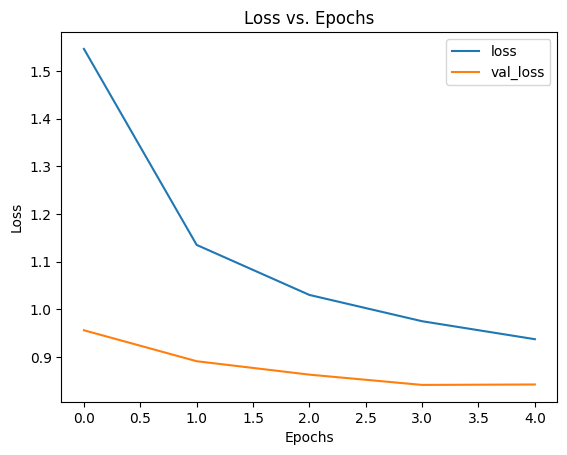

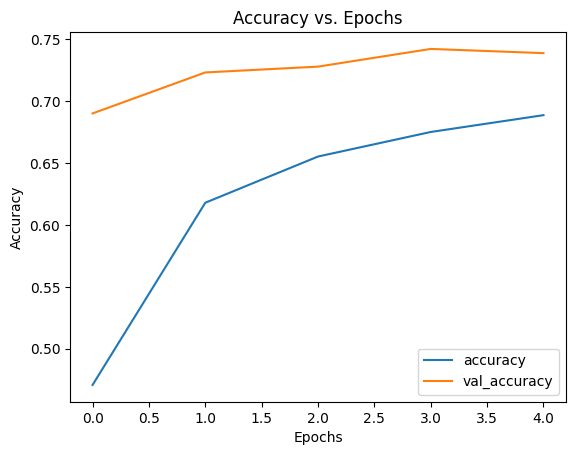

In [42]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_4_history, 'accuracy')

In [43]:
model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_4)
model_4_results

ClassificationPredictionMetrics(accuracy=0.7388, precision=0.7724268372022299, recall=0.7388, f1=0.7449638228868005, name='model_4_conv_conv_pool_aug')

#### Findings

Well this performed terribly! This is kind of expected though for two reasons:

1. The images themselves are all upright and pretty consistent, so trying to augment it doesn't make a lot of sense in this scenario.
2. Due to the data augmentation with `Height` and `Width` changes, the `Flatten` layer doesn't work, so instead I have to take the `GlobalMaxPooling` of the data. This reduces the number of trainable parameters from ~26,000 to ~2600 (factor of 10 difference).

### Experiment-5: EfficientNet

In [44]:
# Constants
model_5_name = 'model_5_efficient_net'

In [45]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

# Setup Input Shape and BaseModel
base_model_5 = tf.keras.applications.EfficientNetB0(include_top=False, input_shape = (32,32,3))
base_model_5.trainable = False

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = efficientnet_preprocessing(inputs)
x = base_model_5(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax')(x)

model_5 = tf.keras.models.Model(inputs, outputs, name=model_5_name)

model_5.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_5_history = model_5.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=5)

Epoch 1/5
1875/1875 [==============================] - 51s 26ms/step - loss: 0.6915 - accuracy: 0.7646 - val_loss: 0.3789 - val_accuracy: 0.8734
Epoch 2/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.4597 - accuracy: 0.8450 - val_loss: 0.3212 - val_accuracy: 0.8905
Epoch 3/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.4071 - accuracy: 0.8637 - val_loss: 0.2934 - val_accuracy: 0.8971
Epoch 4/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3815 - accuracy: 0.8709 - val_loss: 0.2609 - val_accuracy: 0.9106
Epoch 5/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.3605 - accuracy: 0.8800 - val_loss: 0.2732 - val_accuracy: 0.9054


In [46]:
model_5.summary()

Model: "model_5_efficient_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 efficientnet_preprocessing  (None, 32, 32, 1)         0         
 _layers (Sequential)                                            
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)    

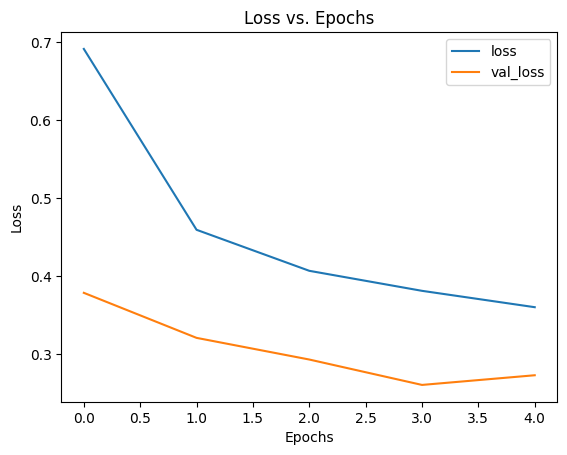

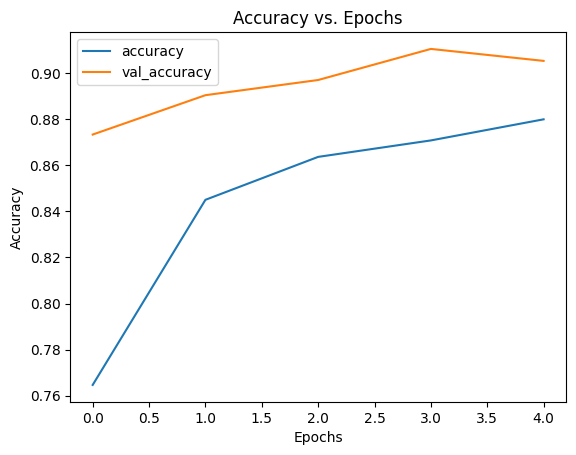

In [47]:
ml_toolbox.analysis.history.plot_history(model_5_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_5_history, 'accuracy')

In [48]:
model_5_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_5)
model_5_results

ClassificationPredictionMetrics(accuracy=0.9054, precision=0.9104512464619962, recall=0.9054, f1=0.9047275148009453, name='model_5_efficient_net')

#### Findings

Well, this is a fairly complex model, and it didn't even come close to performing as well as the conv-conv-pooling model!

### Experiment-6: Double Conv2D-MaxPooling2D w/ Decreased Learning Rate

In [49]:
# Constants
model_6_name = 'model_6_double_conv_pool_llr'

In [50]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    preprocessing,
    tf.keras.layers.Conv2D(16, 5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_6_name)

model_6.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002),
                metrics=['accuracy'])

model_6_history = model_6.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4388 - accuracy: 0.8834 - val_loss: 0.1760 - val_accuracy: 0.9492
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1520 - accuracy: 0.9564 - val_loss: 0.1094 - val_accuracy: 0.9695
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1056 - accuracy: 0.9696 - val_loss: 0.0829 - val_accuracy: 0.9759
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0840 - accuracy: 0.9755 - val_loss: 0.0690 - val_accuracy: 0.9790
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0713 - accuracy: 0.9792 - val_loss: 0.0605 - val_accuracy: 0.9816
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0626 - accuracy: 0.9818 - val_loss: 0.0549 - val_accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0564 - accuracy: 0.9837 - val_loss: 0.0513 - val_accuracy:

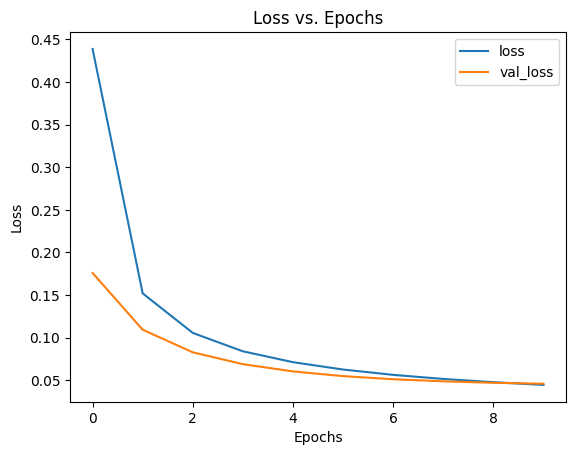

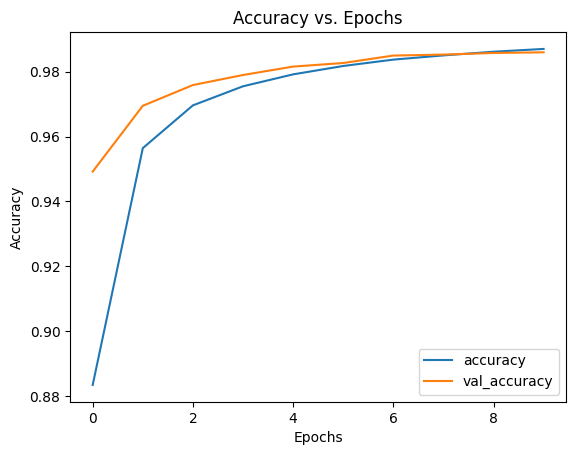

In [51]:
ml_toolbox.analysis.history.plot_history(model_6_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_6_history, 'accuracy')

In [52]:
model_6_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_6)
model_6_results

ClassificationPredictionMetrics(accuracy=0.986, precision=0.986054525686626, recall=0.986, f1=0.9859957462357218, name='model_6_double_conv_pool_llr')

### Experiment-7: Double Conv2D-MaxPooling2D-Dropout w/ Lower Learning Rate

In [53]:
# Constants
model_7_name = 'model_7_double_conv_pool_dropout_llr'

In [54]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    preprocessing,
    tf.keras.layers.Conv2D(16, 5),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_7_name)

model_7.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002),
                metrics=['accuracy'])

model_7_history = model_7.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5203 - accuracy: 0.8539 - val_loss: 0.1963 - val_accuracy: 0.9437
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2045 - accuracy: 0.9415 - val_loss: 0.1266 - val_accuracy: 0.9618
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1515 - accuracy: 0.9563 - val_loss: 0.0933 - val_accuracy: 0.9728
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1257 - accuracy: 0.9635 - val_loss: 0.0775 - val_accuracy: 0.9761
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1093 - accuracy: 0.9684 - val_loss: 0.0679 - val_accuracy: 0.9787
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0964 - accuracy: 0.9719 - val_loss: 0.0612 - val_accuracy: 0.9809
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0879 - accuracy: 0.9750 - val_loss: 0.0566 - val_accuracy:

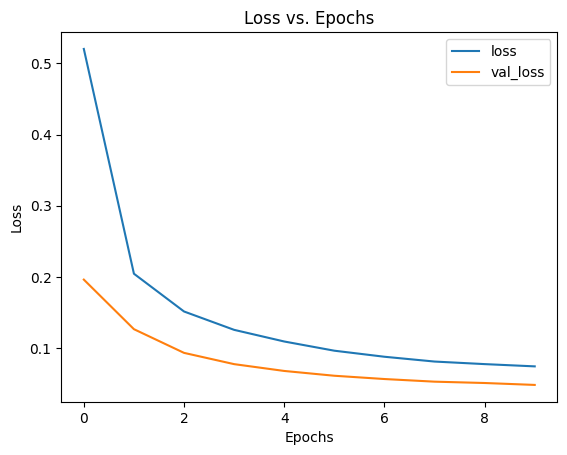

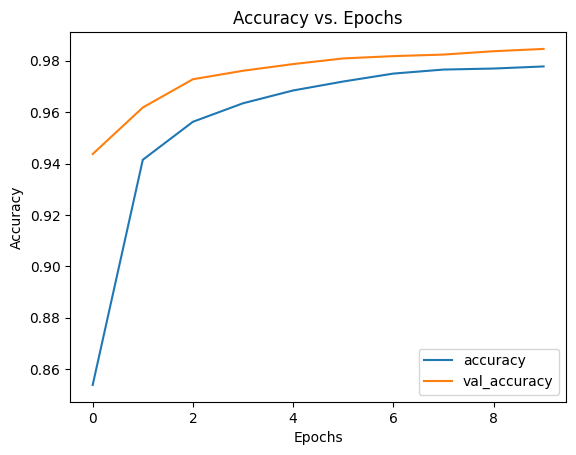

In [55]:
ml_toolbox.analysis.history.plot_history(model_7_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_7_history, 'accuracy')

In [56]:
model_7_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_7)
model_7_results

ClassificationPredictionMetrics(accuracy=0.9846, precision=0.9846265335779569, recall=0.9846, f1=0.9845878445257189, name='model_7_double_conv_pool_dropout_llr')

### Experiment-8: Transfer Learning

In [57]:
# Constants
model_8_name = 'model_8_transfer_learning'

MODEL_URL = 'https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1'

In [58]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_8 = tf.keras.models.Sequential([
    preprocessing,
    hub.KerasLayer(MODEL_URL),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(TOTAL_CLASSES, activation='softmax'),
], name=model_8_name)

model_8.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002),
                metrics=['accuracy'])

model_8_history = model_8.fit(batched_train_dataset,
                              validation_data=batched_test_dataset,
                              epochs=10)

INFO:absl:Using /var/folders/sj/rsg548nx63dc931tmwt4nnq80000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.7592 - accuracy: 0.8101 - val_loss: 0.1078 - val_accuracy: 0.9809
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0756 - accuracy: 0.9848 - val_loss: 0.0566 - val_accuracy: 0.9851
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0478 - accuracy: 0.9879 - val_loss: 0.0446 - val_accuracy: 0.9867
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0385 - accuracy: 0.9898 - val_loss: 0.0398 - val_accuracy: 0.9873
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0341 - accuracy: 0.9905 - val_loss: 0.0373 - val_accuracy: 0.9874
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0316 - accuracy: 0.9909 - val_l

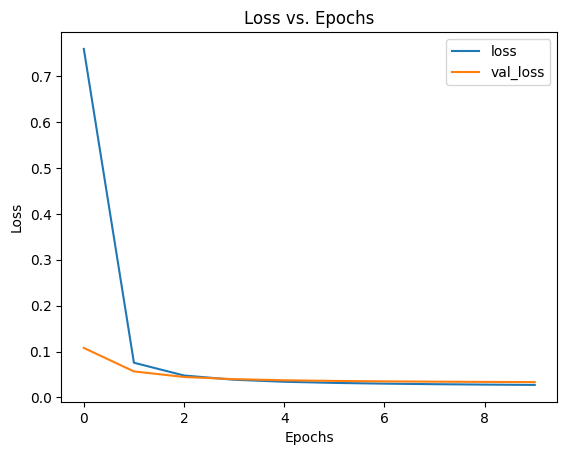

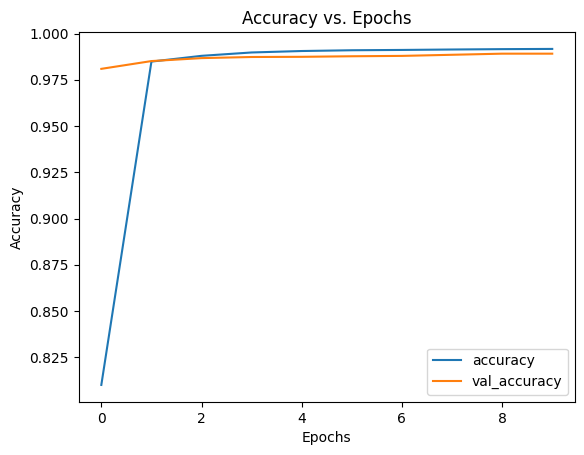

In [59]:
ml_toolbox.analysis.history.plot_history(model_8_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_8_history, 'accuracy')

In [60]:
model_8_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(batched_test_dataset, model_8)
model_8_results

ClassificationPredictionMetrics(accuracy=0.9891, precision=0.9891167353248748, recall=0.9891, f1=0.9891015994789337, name='model_8_transfer_learning')

## Analysis

Now that I have ran a handful of experiments, I want to see how the models compare.

In [61]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_5_results,
    model_6_results,
    model_7_results,
    model_8_results,
]

all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

,accuracy,precision,recall,f1
model_0_feed_forward,0.9468,0.947366,0.9468,0.946817
model_1_conv_pool,0.9749,0.974977,0.9749,0.974877
model_2_conv_conv_pool,0.9737,0.974118,0.9737,0.973724
model_3_conv_conv_pool_reg,0.9724,0.972516,0.9724,0.972390
model_4_conv_conv_pool_aug,0.7388,0.772427,0.7388,0.744964
model_5_efficient_net,0.9054,0.910451,0.9054,0.904728
model_6_double_conv_pool_llr,0.9860,0.986055,0.9860,0.985996
model_7_double_conv_pool_dropout_llr,0.9846,0.984627,0.9846,0.984588
model_8_transfer_learning,0.9891,0.989117,0.9891,0.989102


<Axes: >

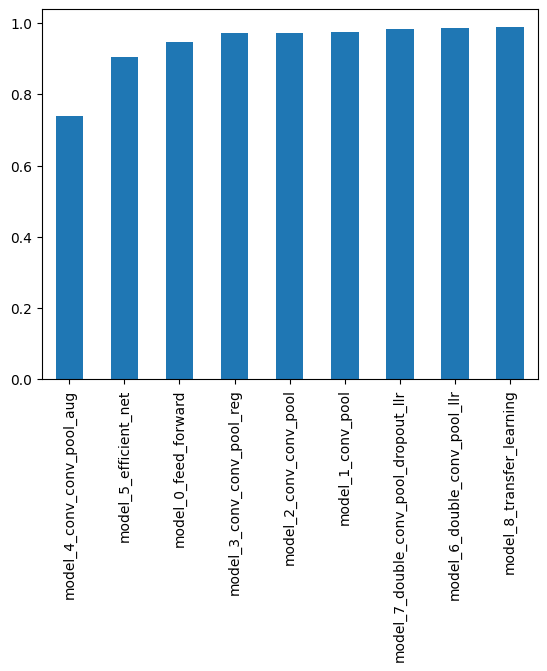

In [62]:
all_results_df['accuracy'].sort_values().plot(kind='bar')